# Deconvolution of the thickness effect

This is the third part of this long journey in the thickness of the silicon sensor of the Pilatus detector:
After characterizing the precise position of the Pilatus-1M on the goniometer of ID28 we noticed there are some discrepancies in the ring position and peak width as function of the position on the detector. 
In a second time the thickness of the detector was modeled and allowed us to define a sparse-matrix which represent the bluring of the signal with a point-spread function which actually depends on the position of the detector.
This convolution can be revereted using techniques developped for inverse problems. 

We will now correct the images of the first notebook called "goniometer" with the sparse matrix calculated in the second one (called "raytracing") and check if the pick-width is less chaotic.

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
import fabio, pyFAI
from os.path import basename
from pyFAI.gui import jupyter
from pyFAI.calibrant import get_calibrant
from silx.resources import ExternalResources

downloader = ExternalResources("thick", "http://www.silx.org/pub/pyFAI/testimages")
all_files = downloader.getdir("gonio_ID28.tar.bz2")
for afile in all_files:
    print(basename(afile))

gonio_ID28
det130_g45_0001p.npt
det130_g0_0001p.cbf
det130_g17_0001p.npt
det130_g0_0001p.npt
det130_g45_0001p.cbf
det130_g17_0001p.cbf


In [4]:
from scipy.sparse import save_npz, load_npz, csr_matrix, csc_matrix, linalg
#Saved in notebook called "raytracing"
csr = load_npz("csr.npz")

<IPython.core.display.Javascript object>


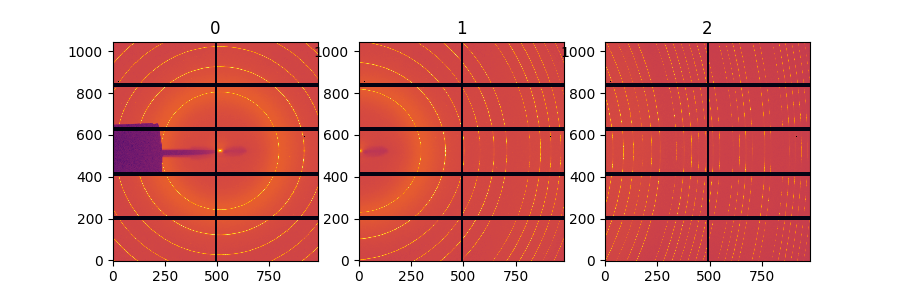

In [5]:
mask = numpy.load("mask.npy")
images = [fabio.open(i).data for i in sorted(all_files) if i.endswith("cbf")]

fig, ax = subplots(1, 3, figsize=(9,3))
for i, img in enumerate(images):
    jupyter.display(img, ax=ax[i], label=str(i))

<IPython.core.display.Javascript object>


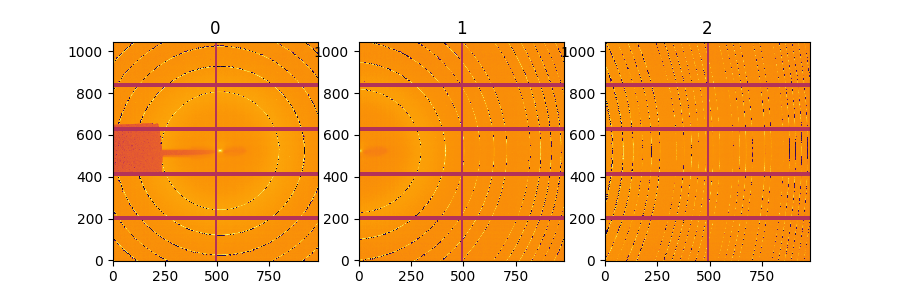

(1, 23, 66.70990774867543, 10.158274084529316, 1.862080761109672, 4.14570503703584, 44893432.24543187)
(1, 23, 58.916672571983064, 9.570956020928959, 1.8666608378909706, 4.014684882558294, 38902819.11094429)
(1, 24, 28.594323261908972, 4.742259572541144, 1.8989416010446072, 3.979698178348962, 16639925.889255311)


In [6]:
fig, ax = subplots(1, 3, figsize=(9,3))

msk = numpy.where(mask)
for i, img in enumerate(images):
    fl = img.astype("float32")
    fl[msk] = 0.0 # set masked values to 0, negative values could induce errors
    bl = fl.ravel()
    res = linalg.lsmr(csr.T, bl)
    print(res[1:])
    cor = res[0].reshape(img.shape)
    jupyter.display(cor, ax=ax[i], label=str(i))

It turns out the deconvolution is not that straight forwards and creates some negative wobbles near the rings. 
This phenomenon is well known in inverse methods which provide a damping factor to limit the effect. This damping factor needs to be adjusted manually to avoid this.

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

<IPython.core.display.Javascript object>


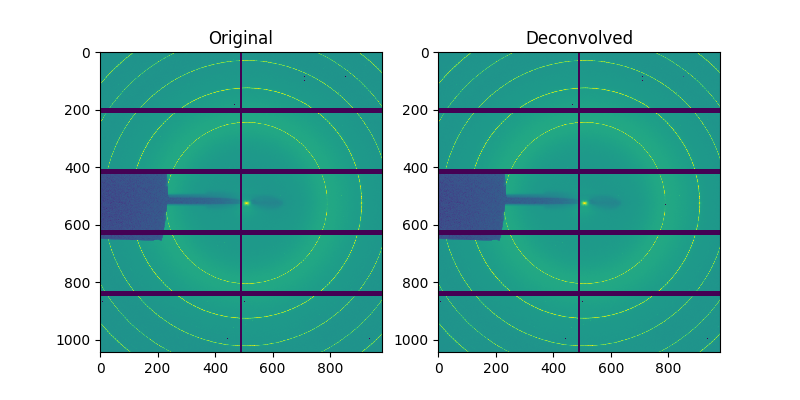

interactive(children=(FloatSlider(value=2.5, description='damp', max=5.0), Output()), _dom_classes=('widget-in…

In [8]:
img = images[0]
fl = img.astype("float32")
fl[msk] = 0.0 # set masked values to 0
blured = fl.ravel()
fig, ax = subplots(1, 2, figsize=(8,4))
im0 = ax[0].imshow(numpy.arcsinh(fl))
im1 = ax[1].imshow(numpy.arcsinh(fl))
ax[0].set_title("Original")
ax[1].set_title("Deconvolved")
def deconvol(damp):
    res = linalg.lsmr(csr.T, blured, damp=damp, x0=blured)
    restored = res[0].reshape(mask.shape)
    im1.set_data(numpy.arcsinh(restored))
    print("Number of negative pixels: %i"%(restored<0).sum())


interactive_plot = widgets.interactive(deconvol, damp=(0, 5.0))
display(interactive_plot)

In [9]:
#selection of the damping factor which provides no negative signal:
tot_neg = 100
damp = 0
while tot_neg>0:
    damp += 0.1
    tot_neg = 0
    deconvoluted = []
    for i, img in enumerate(images):
        fl = img.astype("float32")
        fl[msk] = 0.0 # set masked values to 0
        bl = fl.ravel()
        res = linalg.lsmr(csr.T, bl, damp=damp)
        neg=(res[0]<0).sum()
        print(i, damp, neg, res[1:])
        tot_neg += neg
        deconvoluted.append(res[0].reshape(img.shape))
print("damp:",damp)

0 0.1 12878 (2, 19, 4321884.135361293, 7.074010951940599, 1.6983937332424026, 3.418322362189211, 41657218.597436495)
1 0.1 12253 (2, 20, 3763677.9806941724, 3.9064076506527017, 1.7452525047433998, 3.465821286493578, 36450688.50963276)
2 0.1 17600 (2, 21, 1583946.6921666162, 1.574384872251202, 1.7788878723455084, 3.533592727492693, 15124377.449024988)
0 0.2 11660 (2, 14, 7888849.840813451, 5.6256238990165, 1.4657229620560677, 2.7234917935641367, 34985945.63911174)
1 0.2 10761 (2, 14, 6940346.260818773, 5.069308813199049, 1.4706686758031693, 2.7315255037317834, 31183826.867996864)
2 0.2 15000 (2, 14, 2845633.477604854, 3.1371817873604617, 1.4635181990763593, 2.724887437187385, 12406590.525113052)
0 0.30000000000000004 9562 (2, 11, 10555838.622432956, 4.20839712065412, 1.3062416003381532, 2.2651196103286124, 28199162.180749137)
1 0.30000000000000004 9076 (2, 11, 9374222.650981324, 3.6531487918548224, 1.3123977257980646, 2.239973977214254, 25515416.35763568)
2 0.30000000000000004 12266 (2,

0 2.3000000000000007 11 (2, 3, 18024330.414405737, 7.930151673447729, 0.720876988061102, 1.0062728529491656, 1487366.5963699264)
1 2.3000000000000007 1 (2, 3, 16407398.656373791, 6.8091926800413205, 0.731367160508006, 1.0068212556343274, 1387509.7429811088)
2 2.3000000000000007 0 (2, 3, 6298827.381371127, 3.3670339083613476, 0.7124343038688561, 1.0065496203475917, 508721.78920936125)
0 2.400000000000001 10 (2, 3, 18050885.482207403, 6.190770510719561, 0.720876988061102, 1.0057648353847268, 1370394.7294064607)
1 2.400000000000001 1 (2, 3, 16432786.531270344, 5.316868504466503, 0.731367160508006, 1.0062702038899327, 1278480.911507325)
2 2.400000000000001 0 (2, 3, 6307716.503634095, 2.6280467076275253, 0.7124343038688561, 1.0060170869830354, 468680.40103613574)
0 2.500000000000001 7 (2, 3, 18074427.72210949, 4.879196016218006, 0.720876988061102, 1.0053159690213513, 1266551.691812879)
1 2.500000000000001 1 (2, 3, 16455295.419743016, 4.19126852745269, 0.731367160508006, 1.0057831172796328, 

In [10]:
# damp = 1
# deconvoluted = []
# for i, img in enumerate(images):
#     fl = img.astype("float32")
#     fl[msk] = 0.0 # set masked values to 0
#     bl = fl.ravel()
#     res = linalg.lsmr(csr.T, bl, damp=damp)
#     neg=(res[0]<-1).sum()
#     print(i, damp, neg, res[1:])
#     tot_neg += neg
#     deconvoluted.append(res[0].reshape(img.shape))
    

<IPython.core.display.Javascript object>


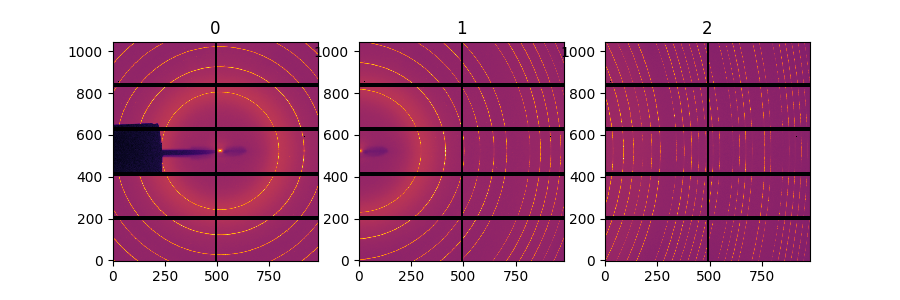

In [11]:
fig, ax = subplots(1, 3, figsize=(9,3))
for i,img in enumerate(deconvoluted):
    jupyter.display(img, ax=ax[i], label=str(i))

At this point we are back to the initial state: can we fit the goniometer and check the width of the peaks to validate if it got better.

In [12]:
wavelength=0.6968e-10
calibrant = get_calibrant("LaB6")
calibrant.wavelength = wavelength
print(calibrant)

detector =  pyFAI.detector_factory("Pilatus1M")
detector.mask = mask

fimages = []
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[0], header={"angle":0}))
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[1], header={"angle":17}))
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[2], header={"angle":45}))

LaB6 Calibrant with 120 reflections at wavelength 6.968e-11


In [13]:
def get_angle(metadata):
    """Takes the basename (like det130_g45_0001.cbf ) and returns the angle of the detector"""
    return metadata["angle"]

In [14]:
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

In [15]:
gonioref2d = GoniometerRefinement.sload("id28.json", pos_function=get_angle)

In [16]:
for idx, fimg in enumerate(fimages):
    sg = gonioref2d.new_geometry(str(idx), image=fimg.data, metadata=fimg.header, calibrant=calibrant)
    print(sg.label, "Angle:", sg.get_position())

0 Angle: 0
1 Angle: 17
2 Angle: 45


<IPython.core.display.Javascript object>


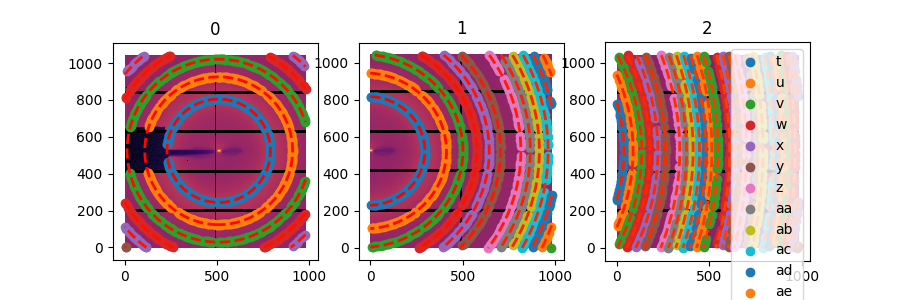

ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 6 groups of points:
# a ring 0: 348 points
# b ring 1: 341 points
# c ring 2: 316 points
# d ring 3: 129 points
# e ring 4: 48 points
# f ring 5: 2 points


ControlPoints instance containing 13 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 13 groups of points:
# g ring 0: 177 points
# h ring 1: 172 points
# i ring 2: 168 points
# j ring 3: 123 points
# k ring 4: 106 points
# l ring 5: 94 points
# m ring 6: 80 points
# n ring 7: 77 points
# o ring 8: 71 points
# p ring 9: 67 points
# q ring 10: 37 points
# r ring 11: 16 points
# s ring 12: 1 points


ControlPoints instance containing 26 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 26 groups of points:
# t ring 7: 37 points
# u ring 8: 54 points
# v ring 9: 66 points
# w ring 10: 64 points
# x ring 11: 62 points
# y ring 12: 61 points
# z ring 13: 57 points
#aa ring 14: 55 points
#ab ring 15: 55 points
#ac ring 16: 53 points
#ad ring 17: 53 points
#ae ring 18: 47 points
#af ring 19: 50 points
#ag ring 20: 49 points
#ah ring 21: 47 points
#ai ring 22: 47 points
#aj ring 23: 45 points
#ak ring 24: 45 points
#al ring 25: 43 points
#am ring 26: 43 points
#an ring 27: 42 points
#ao ring 28: 41 points
#ap ring 29: 41 points
#aq ring 30: 41 points
#ar ring 31: 19 points
#as ring 32: 2 points


In [17]:
fig,ax = subplots(1,3, figsize=(9,3))
for lbl, sg in gonioref2d.single_geometries.items():
    idx = int(lbl)
    print(sg.extract_cp())
    jupyter.display(sg=sg, ax=ax[idx])

In [18]:
gonioref2d.refine2()

Cost function before refinement: 3.349407535439659e-08
[ 2.84547605e-01  8.86540301e-02  8.93070277e-02  5.48717450e-03
  5.54901577e-03  1.74619285e-02 -2.09889821e-05]
     fun: 1.9744224255740207e-08
     jac: array([-4.11280398e-07,  5.36569840e-07, -6.12422133e-07,  1.52005813e-07,
        1.91376555e-07, -2.77401676e-06, -2.07159630e-06])
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 2.84372928e-01,  8.86574241e-02,  8.93041357e-02,  5.48725744e-03,
        5.54952449e-03,  1.74617337e-02, -2.08382694e-05])
Cost function after refinement: 1.9744224255740207e-08
GonioParam(dist=0.2843729279671324, poni1=0.08865742412380148, poni2=0.08930413571932551, rot1=0.005487257441030818, rot2=0.0055495244912874735, scale1=0.01746173366959066, scale2=-2.0838269355975054e-05)
maxdelta on: dist (0) 0.2845476046521533 --> 0.2843729279671324


array([ 2.84372928e-01,  8.86574241e-02,  8.93041357e-02,  5.48725744e-03,
        5.54952449e-03,  1.74617337e-02, -2.08382694e-05])

  File "/users/kieffer/.venv/py37/lib/python3.7/site-packages/pyFAI/multi_geometry.py", line 149, in integrate1d
    mask=mask, flat=flat)


MultiGeometry integrator with 3 geometries on (0, 63) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


<IPython.core.display.Javascript object>


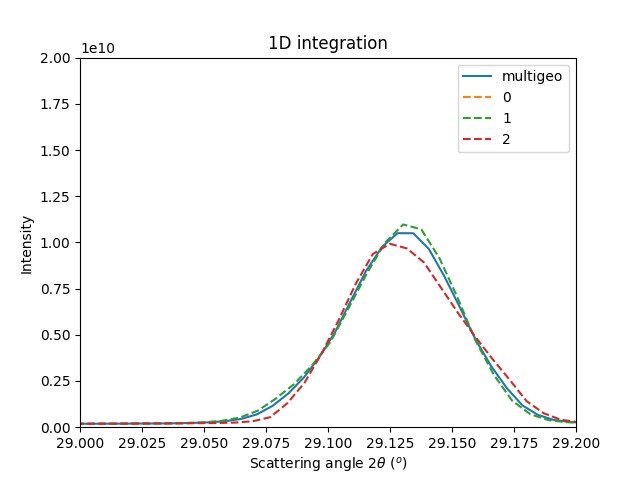

  File "<ipython-input-19-52daf54a04c0>", line 19, in <module>
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")


In [19]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
dimages = []
for sg in gonioref2d.single_geometries.values():
    angles.append(sg.get_position())
    dimages.append(sg.image)

multigeo = gonioref2d.get_mg(angles)
multigeo.radial_range=(0, 63)
print(multigeo)
# Integrate the whole set of images in a single run:

res_mg = multigeo.integrate1d(dimages, 10000)
ax = jupyter.plot1d(res_mg, label="multigeo")
for lbl, sg in gonioref2d.single_geometries.items():
    ai = gonioref2d.get_ai(sg.get_position())
    img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
    ax.plot(*res, "--", label=lbl)
ax.legend()

In [20]:
#Let's focus on the inner most ring on the image taken at 45°:
#ax.set_xlim(21.5, 21.7)
ax.set_xlim(29.0, 29.2)
ax.set_ylim(0, 2e10)

(0, 20000000000.0)

<IPython.core.display.Javascript object>


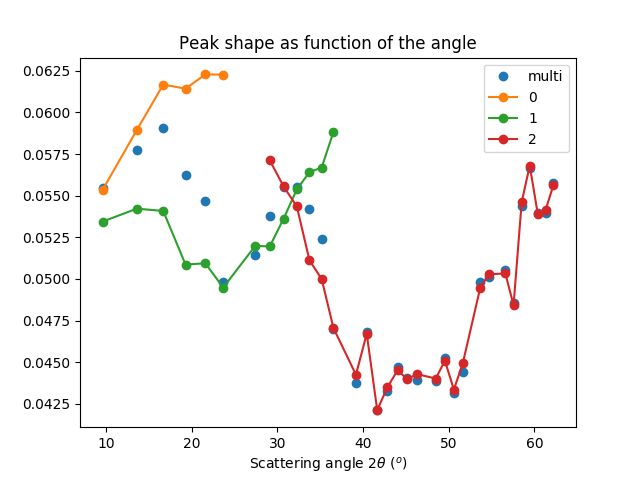

  File "<ipython-input-21-dc6d9f0ee241>", line 51, in <module>
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")


In [21]:
#Peak FWHM

from scipy.interpolate import interp1d
from scipy.optimize import bisect

def calc_fwhm(integrate_result, calibrant):
    "calculate the tth position and FWHM for each peak"
    delta = integrate_result.intensity[1:] - integrate_result.intensity[:-1]
    maxima = numpy.where(numpy.logical_and(delta[:-1]>0, delta[1:]<0))[0]
    minima = numpy.where(numpy.logical_and(delta[:-1]<0, delta[1:]>0))[0]
    maxima += 1
    minima += 1
    tth = []
    FWHM = []
    for tth_rad in calibrant.get_2th():
        tth_deg = tth_rad*integrate_result.unit.scale
        if (tth_deg<=integrate_result.radial[0]) or (tth_deg>=integrate_result.radial[-1]):
            continue
        idx_theo = abs(integrate_result.radial-tth_deg).argmin()
        id0_max = abs(maxima-idx_theo).argmin()
        id0_min = abs(minima-idx_theo).argmin()
        I_max = integrate_result.intensity[maxima[id0_max]]
        I_min = integrate_result.intensity[minima[id0_min]]
        tth_maxi = integrate_result.radial[maxima[id0_max]]
        I_thres = (I_max + I_min)/2.0
        if minima[id0_min]>maxima[id0_max]:
            if id0_min == 0:
                min_lo = integrate_result.radial[0]
            else:
                min_lo = integrate_result.radial[minima[id0_min-1]]
            min_hi = integrate_result.radial[minima[id0_min]]
        else:
            if id0_min == len(minima) -1:
                min_hi = integrate_result.radial[-1]
            else:
                min_hi = integrate_result.radial[minima[id0_min+1]]
            min_lo = integrate_result.radial[minima[id0_min]]
            
        f = interp1d(integrate_result.radial, integrate_result.intensity-I_thres)
        tth_lo = bisect(f, min_lo, tth_maxi)
        tth_hi = bisect(f, tth_maxi, min_hi)
        FWHM.append(tth_hi-tth_lo)
        tth.append(tth_deg)
    return tth, FWHM
    
fig, ax = subplots()
ax.plot(*calc_fwhm(res_mg, calibrant), "o", label="multi")
for lbl, sg in gonioref2d.single_geometries.items():
    ai = gonioref2d.get_ai(sg.get_position())
    img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
    t,w = calc_fwhm(res, calibrant=calibrant)
    ax.plot(t, w,"-o", label=lbl)
ax.set_title("Peak shape as function of the angle")
ax.set_xlabel(res_mg.unit.label)
ax.legend()


## conclusion:
The results do not look enhanced compared to the initial fit: neither the peak position, nor the FWHM looks enhanced. Maybe there is an error somewhere.